# Process frames (grayscale, edges)

In [137]:
dir = "../../dataset/horseactionrecognition/crop_"
labels = ["canter", "trot", "walk"]
suffix = "pic_noback/"

# dir + label[0] + suffix + label[0] + str(sample).zfill(4)

In [203]:

import cv2
import os
import numpy as np

#notebook
import time

label = "walk"
sample = 1
    
src = dir + label + suffix + label + str(sample).zfill(4) + "/"
grayscale_dir = "../dataset/preprocessed/grayscale/" + label + '/' + str(sample).zfill(4) + "/"
edges_dir = "../dataset/preprocessed/edges/" + label + '/' + str(sample).zfill(4) + "/"

os.makedirs(grayscale_dir, exist_ok=True)
os.makedirs(edges_dir, exist_ok=True)

t0 = time.time()
files = sorted(os.listdir(src))
t1 = time.time()
print(f"Found {len(files)} files in {t1 - t0:.4f} seconds.")

for frame in files:
    img = cv2.imread(src + frame)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray_float = gray / 255.0
    np.save(grayscale_dir + os.path.splitext(frame)[0], gray_float)
    
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_mag = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    values = grad_mag[grad_mag > 0].ravel()

    t2 = np.percentile(values, 95)
    t1 = 0.4 * t2

    edges = cv2.Canny(img, t1, t2)
    edges_float = edges / 255.0
    np.save(edges_dir + os.path.splitext(frame)[0], edges_float)

print(f"Loaded {len(files)} frames for action '{label}'")



Found 397 files in 0.0040 seconds.
Loaded 397 frames for action 'walk'


### Normalise names

In [ ]:
label = "walk"
sample = 1

gray_dir = "../../dataset/preprocessed/grayscale/" + label + '/' + label + str(sample).zfill(4) + "/"
edge_dir = "../../dataset/preprocessed/edges/" + label + '/' + label + str(sample).zfill(4) + "/"

names = sorted(os.listdir(gray_dir))

#rename to start from 1
for i, name in enumerate(names):
    new_name = str(i+1).zfill(7) + ".npy"
    os.rename(gray_dir + name, gray_dir + new_name)
    os.rename(edge_dir + name, edge_dir + new_name)

### Load some frames for preview cause "I don't trust what I can't see"

[[0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


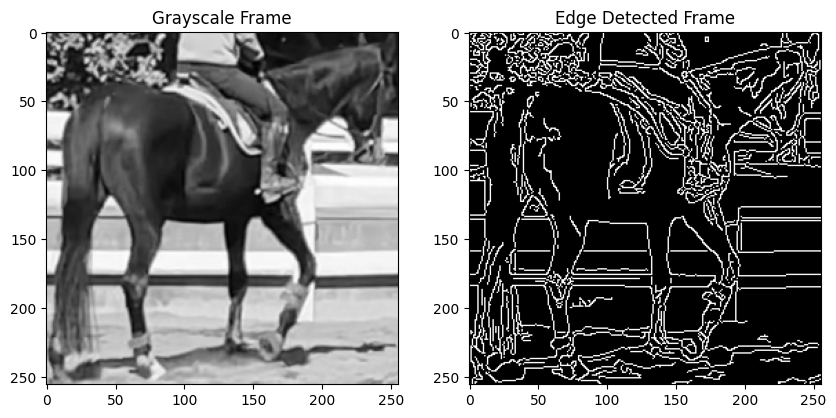

In [208]:
import matplotlib.pyplot as plt
import numpy as np

gray_dir = "../dataset/preprocessed/grayscale/walk/0001/0000001.npy"
edge_dir = "../dataset/preprocessed/edges/walk/0001/0000001.npy"

gray_frame = np.load(gray_dir)
edge_frame = np.load(edge_dir)

print(edge_frame[100:110, 100:110])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Grayscale Frame")
plt.imshow(gray_frame, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Edge Detected Frame")
plt.imshow(edge_frame, cmap='gray')
plt.show()

# Count edge variance for short samples

In [247]:
sample = 1
label = "walk"
edges_dir = "../../dataset/preprocessed/edges/" + label + '/' + label + str(sample).zfill(4) + "/"

edges_dir = "../dataset/preprocessed/edges/" + label + "/0001/"

T = 32

sum_ = np.zeros((256,256), dtype=np.float32)
sum_sq = np.zeros((256,256), dtype=np.float32)

for i in range(T):
    frame = np.load(edges_dir + f"{str(i+1).zfill(7)}.npy").astype(np.float32)
    sum_ += frame
    sum_sq += frame ** 2
    
mean = sum_ / T
var = (sum_sq / T) - (mean ** 2)

image = cv2.normalize(var, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imshow("Variance Image", image)
cv2.waitKey(0)


cv2.destroyAllWindows()

### Count samples

In [240]:
var_dir = "../../dataset/variance/"

sum = 0
for label in labels:
    cnt = len(os.listdir(var_dir + label + "/"))
    print(f'Dataset size for {label}: {cnt}')
    sum += cnt
    
print(f"All samples: {sum}")

Dataset size for canter: 122
Dataset size for trot: 103
Dataset size for walk: 76
All samples: 301


# Edge variance v2

In [248]:
sum_ = np.zeros((256,256), dtype=np.float32)
sum_sq = np.zeros((256,256), dtype=np.float32)

for i in range(T-1):
    t1 = np.load(edges_dir + f"{str(i+1).zfill(7)}.npy").astype(np.float32)
    t2 = np.load(edges_dir + f"{str(i+2).zfill(7)}.npy").astype(np.float32)
    diff = t2 - t1
    
    sum_ += diff
    sum_sq += diff ** 2
    
mean = sum_ / T
var = (sum_sq / T) - (mean ** 2)

image = cv2.normalize(var, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imshow("Variance Image", image)
cv2.waitKey(0)


cv2.destroyAllWindows()

[[2577.327  2388.7544 2358.7822 2499.8047 2532.3174 1853.2129 1816.5342
  1829.5394 2151.9207 2360.4075]
 [2243.261  2660.2334 3124.0444 3191.1023 1677.645  1713.0018 1660.4746
  1934.3921 2750.5579 1781.2781]
 [2444.9404 2178.3374 1883.998  2166.0435 1632.1274 2948.477  2195.3044
  1907.5695 2705.0398 2259.2122]
 [2761.9375 2735.927  2086.3877 2292.842  3637.7422 2828.5874 2176.6104
  1692.1741 2600.5938 3205.7327]
 [2477.3508 1823.0369 2418.9297 1682.5221 2644.8918 2486.7998 3303.27
  2629.855  1774.2682 1514.981 ]
 [2758.5835 1335.3492 2865.977  2254.7417 2886.7034 1734.5416 2742.4297
  2906.211  1901.0667 2552.1294]
 [2785.406  1709.2432 1761.7715 2112.906  2060.378  2344.8618 2010.7964
  2504.9863 1684.1472 2503.462 ]
 [1919.7622 2180.6746 1890.6018 2436.812  2431.021  2678.9285 2223.7534
  2356.242  1285.8694 2053.1643]
 [2692.035  1989.7654 1513.4569 1892.2275 1936.8302 2705.751  2145.7234
  2774.0264 1793.0642 1758.5197]
 [2248.2395 2690.4092 2454.2874 2863.945  1910.0076 1730.

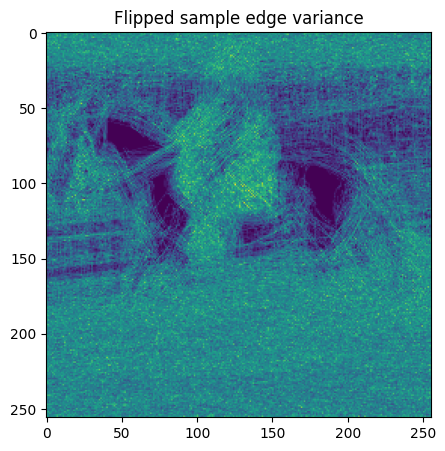

In [242]:
import matplotlib.pyplot as plt
import numpy as np

dir = "../../dataset/variance_aug/canter/canter0001_flipped.npy"

frame = np.load(dir)

print(frame[100:110, 100:110])

plt.figure(figsize=(10, 5))
plt.title("Flipped sample edge variance")
plt.imshow(frame)
plt.show()

# Reduce dimentions